In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep

# Tagging Using Custom Built NN with Pytorch

In [2]:
def add_labels(z: float)->int:
    """
    Add labels according to z-vertex  position
    """
    if -800.0 < z < -500.0 :
        return 0 #Collimeter
    if -500 < z <-305.0:
        return 1 # Air1
    if -305.0 < z < -295.0:
        return 2 # Target
    if -295.0 < z < 0.0:
        return 3 # Air2
    if 0.0 < z < 250.0:
        return 4 # Beam Dump (FMAG)
    else:
        return -99 # some error check the conditions
    

### Read the file

In [3]:
df = pd.read_csv('events-200k.csv')

### Get Hot ID for Z-vertex

In [4]:
hot_id = df['true_vtz'].apply(add_labels).to_numpy()
#hot_id

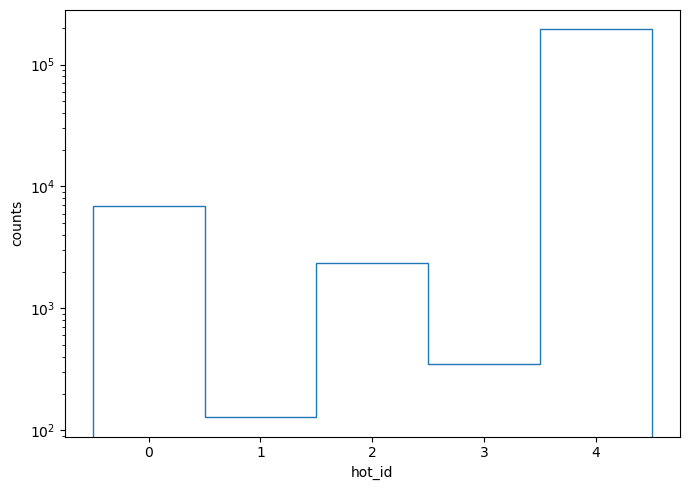

In [5]:
plt.figure(figsize=(7,5))
plt.hist(hot_id, bins = 5, range=[-0.5, 4.5], histtype='step')
plt.yscale('log')
plt.xlabel('hot_id')
plt.ylabel('counts')
plt.tight_layout()
plt.show()

In [6]:
X = df[['q1', 'reco_x1', 'reco_y1', 'reco_z1', 'reco_x3', 'reco_y3', 'reco_z3', 'reco_px1', 'reco_py1', 'reco_pz1', 'reco_px3', 'reco_py3', 'reco_pz3']].to_numpy()
y = df[['true_vtx', 'true_vty', 'true_vtz', 'true_vpx', 'true_vpy', 'true_vpz']].to_numpy()
reco = df[['reco_vtx', 'reco_vty', 'reco_vtz', 'reco_vpx', 'reco_vpy', 'reco_vpz']].to_numpy()

In [7]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
hot_id = ohe.fit_transform(hot_id.reshape(-1, 1))

# Train - Test Split

In [8]:

from sklearn.model_selection import train_test_split
# train, validate test split (60:20:20)
X_train, X_test, y_train, y_test, hotid_train, hotid_test, reco_train, reco_test \
= train_test_split(X, y, hot_id, reco, test_size=0.2, shuffle=True)

X_train, X_valid, y_train, y_valid, hotid_train, hotid_valid \
= train_test_split(X_train, y_train, hotid_train, test_size=0.25, shuffle=True) #0.25 x 0.8= 0.2

## Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler()
X_train = stdscaler.fit_transform(X_train)
X_valid = stdscaler.transform(X_valid)
X_test = stdscaler.transform(X_test)

# Functions for implementing NN

In [10]:
import torch
import torch.nn.functional as F #includes various activation function
from torch.nn import Linear

In [11]:
class vertexTag(torch.nn.Module):
    def __init__(self, in_features: int = 13, out_features: int=5, hidden_dim: int=64):
        super(vertexTag, self).__init__()
        self.fc1=torch.nn.Linear(in_features,hidden_dim, bias=True) 
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc5 = torch.nn.Linear(hidden_dim, out_features, bias=True)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc5(x)
        return x

<details><summary>Click here for the code explanation</summary>

**torch.nn.functional as F**: The functional API of PyTorch's neural network module, which includes various activation functions.</br>
**from torch.nn import Linear**: Importing the Linear class from the torch.nn module.

**vertexTag** 
- inherits from the **torch.nn.Module** class, which is the base class for all neural network modules in PyTorch.
-  calls the __init__ method of the parent class using **super(vertexTag, self).__init__()**
-  defines the layers of the neural network using the **torch.nn.Linear** class
    - **self.fc1** is the first linear layer, which takes in_features as input and produces hidden_dim as output.
    - **self.fc2** and **self.fc3** are additional linear layers with hidden_dim as both input and output dimensions.
    - **self.fc5** is the final linear layer that maps hidden_dim to out_features.
 
**forward** </br>
The forward method defines the forward pass of the neural network.
- It takes an input tensor**x**.
- It passes **x** through the linear layers and applies ReLU activation (**F.relu**) after each linear layer.
- The output of the last linear layer (**self.fc5(x)**) is returned as the final output of the forward pass.
</details>


In [12]:
class vertexReg(torch.nn.Module):
    def __init__(self, in_features: int=13, out_features: int=6, hidden_dim: int=32):
        super(vertexReg, self).__init__()
        self.fc1 = torch.nn.Linear(in_features, hidden_dim, bias=True)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc3 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc4 = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.fc5 = torch.nn.Linear(hidden_dim, out_features, bias=True)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        # x = F.relu(self.fc5(x))
        x = self.fc5(x)
        return x

In [13]:
class vertexMLP(torch.nn.Module):
    def __init__(self, in_features: int=13, hotid_dim: int=5, vert_dim: int=6, hidden_dim1: int=64, hidden_dim2: int=64):
        super(vertexMLP, self).__init__()
        self.fc1 = vertexTag(in_features, hotid_dim, hidden_dim1)
        self.fc2 = vertexReg(in_features+hotid_dim, vert_dim, hidden_dim2)
        
    def forward(self, x):
        pred_hotid = self.fc1(x)
        pred_vert = self.fc2(torch.cat([x, pred_hotid], axis=-1))
        return pred_hotid, pred_vert

<details><summary>Click here for the code explanation</summary>
    
- The **vertexTag** module takes an input tensor **x** and produces an output tensor **pred_hotid**.
- The **vertexReg** module takes the concatenation of **x** and **pred_hotid** and produces an output tensor **pred_vert**.

This model can be used to make predictions for vertex-related tasks, where pred_hotid represents the predicted hotid (hot identifier) and pred_vert represents the predicted vertex.
</details>


In [14]:
net = vertexMLP(hidden_dim1=32, hidden_dim2=32)
print(net)

vertexMLP(
  (fc1): vertexTag(
    (fc1): Linear(in_features=13, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=5, bias=True)
  )
  (fc2): vertexReg(
    (fc1): Linear(in_features=18, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=6, bias=True)
  )
)


In [15]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64 #the number of samples that will be processed in each iteration of the training and validation loops
train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train), torch.Tensor(hotid_train))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.Tensor(X_valid), torch.Tensor(y_valid), torch.Tensor(hotid_valid))
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [16]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':1.5f'):
        self.name = name
        self.fmt = fmt
        self.reset()
        
    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
    def __str__(self):
        fmtstr = '{avg' + self.fmt + '} ({name})'
        return fmtstr.format(**self.__dict__)

<details><summary>Click here for the code explanation</summary>

**AverageMeter** class provides a convenient way to compute and store the average and current values of a metric. 
It allows for updating the meter with new values, resetting it to its initial state, and obtaining a string representation 
of the meter for display purposes. 
- used in training loops to keep track of metrics such as loss or accuracy.   

</details>

In [17]:
tag_criterion = torch.nn.CrossEntropyLoss()
reg_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005, weight_decay=0.000001)
epochs = 150

In [18]:
tag_acc, tag_loss = AverageMeter('TagAccuracy'), AverageMeter('TagLoss')
reg_acc, reg_loss = AverageMeter('RegAccuracy'), AverageMeter('RegLoss')
tag_train_loss, tag_val_acc, tag_val_loss = [], [], []
reg_train_loss, reg_val_acc, reg_val_loss = [], [], []


In [19]:
# Iterate over the dataset <epochs> times
for epoch in range(epochs):

    alpha = 0.0005

    # Set the model to training mode
    net.train()
    
    # Reset our meters
    tag_loss.reset()
    tag_acc.reset()
    reg_loss.reset()

    # Iterate over batches
    for inputs, targets, hot_id in train_dataloader:
        
        
        # Remove previous gradients
        optimizer.zero_grad()

        # Feed forward the inputs
        pred_hotid, pred_vtx = net(inputs)

        # Compute the loss and accuracy
        tag_loss_batch = tag_criterion(pred_hotid, hot_id)
        tag_loss.update(tag_loss_batch.data)


        preds = torch.argmax(pred_hotid, dim=-1)
        accuracy = (torch.argmax(hot_id, dim=-1) == preds).sum() / len(hot_id)
        tag_acc.update(accuracy.data)


        reg_loss_batch = reg_criterion(pred_vtx, targets)
        reg_loss.update(reg_loss_batch.data)

        total_loss_batch = tag_loss_batch + alpha* reg_loss_batch ## ?????
        
        # Compute the gradients
        #perform backpropagation and compute gradients for the parameters of a neural network based on a given loss value
        total_loss_batch.backward() 

        # Update parameters
        optimizer.step()


    tag_train_loss.append(tag_loss.avg)
    reg_train_loss.append(reg_loss.avg)
    #tag_train_acc.append(tag_acc.avg) ???????

    # Validation for each epoch
    net.eval()
    tag_loss.reset()
    tag_acc.reset()
    reg_loss.reset()

    for inputs, targets, hot_id in val_dataloader:
        
        pred_hotid, pred_vtx = net(inputs)
        
        tag_loss_batch = tag_criterion(pred_hotid, hot_id)
        tag_loss.update(tag_loss_batch.data)

        preds = torch.argmax(pred_hotid, dim=-1)
        accuracy = (torch.argmax(hot_id, dim=-1) == preds).sum() / len(hot_id)
        tag_acc.update(accuracy.data)

        reg_loss_batch =reg_criterion(pred_vtx, targets)
        reg_loss.update(reg_loss_batch.data)


    tag_val_loss.append(tag_loss.avg)
    tag_val_acc.append(tag_acc.avg)
    reg_val_loss.append(reg_loss.avg)
    

<details><summary>Click here for the code explanation</summary>

**torch.argmax()**: It is a function in PyTorch that returns the indices of the maximum values in a tensor.
**dim=-1**: It specifies the dimension along which the maximum values are computed.
**torch.argmax(pred_hotid, dim=-1)** is used to find the indices of the maximum values in the tensor pred_hotid along the last dimension.

**net.eval()** is a method typically used to switch a neural network model to evaluation mode.
- dropout layers are activated (regularization)
- gradients won't be calculated for any parameters of the model. This behavior saves memory and speeds up computation since gradients are not needed during inference.


</details>

In [20]:
def draw_loss(data_train, data_val, data_acc, label="Loss"):
    """Plots the training and validation loss"""

    fig, ax1 = plt.subplots(figsize=(5, 5))
    ax1.set_xlabel("Epoch", horizontalalignment='right', x=1.0)
    ax1.set_ylabel("Loss", horizontalalignment='right', y=1.0)
    ax1.set_yscale('log')
    ax1.tick_params(axis='y', labelcolor='red')
    ax1.plot(data_train,
             color='red',
             label='Training loss')
    ax1.plot(data_val,
             color='blue',
             label='Validation loss')
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.plot(data_acc,
             color='green',
             label='Accuracy')
    ax1.legend(loc='lower left')
    ax2.legend(loc='upper left')
    # plt.tight_layout()
    #plt.savefig('imgs/cls-loss.png')
    plt.show()

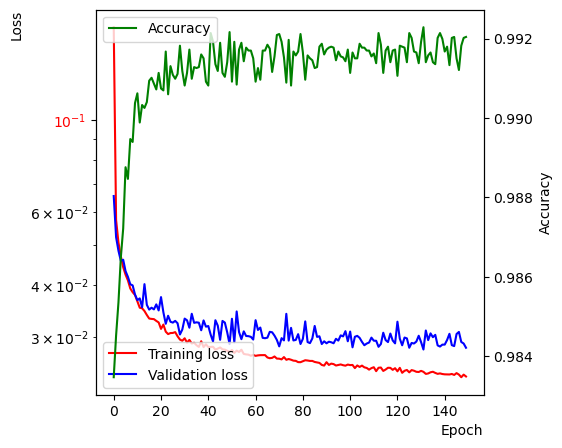

In [21]:
draw_loss(tag_train_loss, tag_val_loss, tag_val_acc)

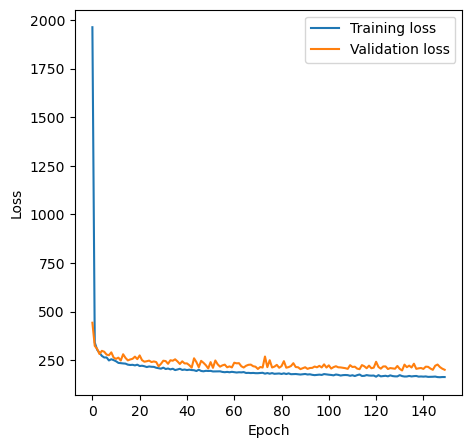

In [22]:
plt.figure(figsize=(5, 5))
plt.plot(reg_train_loss, label='Training loss')
plt.plot(reg_val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# plt.tight_layout()
# plt.savefig('imgs/reg-loss.png')
plt.show()

In [23]:
from sklearn.metrics import accuracy_score

net.eval()
pred_hotid, y_pred = net(torch.tensor(X_test).unsqueeze(0).float())

print("Accuracy for the test set: {0:.4f}".format(
    accuracy_score(
        np.argmax(hotid_test, axis=1),
        torch.argmax(pred_hotid, dim=-1).squeeze().numpy())
))

Accuracy for the test set: 0.9923


<details><summary>Click here for the code explanation</summary>
    
**torch.tensor(X_test).unsqueeze(0).float()** creates a PyTorch tensor from the test data array X_test, adds a batch dimension, and converts the data type to float. This resulting tensor can then be fed into the neural network model for evaluation or prediction.


</details>

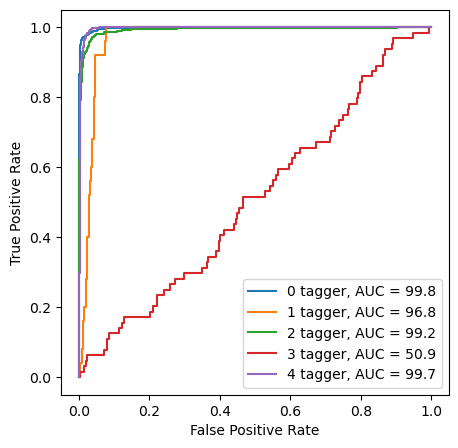

In [24]:
from sklearn.metrics import roc_curve, auc

def plot_roc(y_test, y_pred, labels):
    for x in range(5):
        fpr, tpr, _ = roc_curve(y_test[:, x], y_pred[:, x])
        plt.plot(fpr, tpr, label='{0} tagger, AUC = {1:.1f}'.format(labels[0][x], auc(fpr, tpr)*100.), linestyle='-')

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.legend(loc='lower right')


plt.figure(figsize=(5, 5))
plot_roc(hotid_test, pred_hotid.squeeze().detach().numpy(), ohe.categories_)
#plt.savefig('imgs/roc-curve.png')

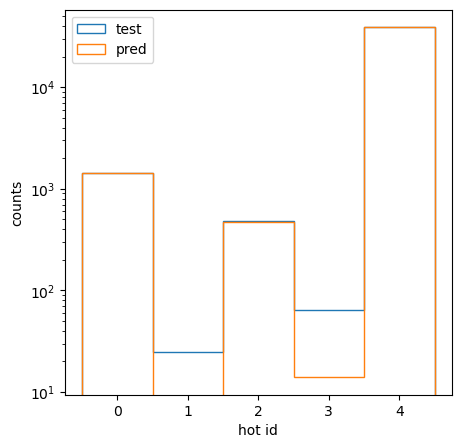

In [25]:
pred_hotid = torch.argmax(pred_hotid, dim=-1).squeeze().detach().numpy()
hotid_test = np.argmax(hotid_test, axis=1)

plt.figure(figsize=(5, 5))
plt.hist(hotid_test, histtype='step', bins=5, range=(-0.5, 4.5), label='test')
plt.hist(pred_hotid, histtype='step', bins=5, range=(-0.5, 4.5), label='pred')
plt.xlabel('hot id')
plt.ylabel('counts')
plt.legend()
plt.yscale('log')
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('imgs/cls-hot-id.png')
plt.show()

<details><summary>Click here for the code explanation</summary>

**torch.argmax(pred_hotid, dim=-1).squeeze().detach().numpy()** takes the tensor pred_hotid, finds the indices of its maximum values, removes unnecessary dimensions, detaches it from the computation graph, and finally converts it into a NumPy array for further processing or analysis.

</details>


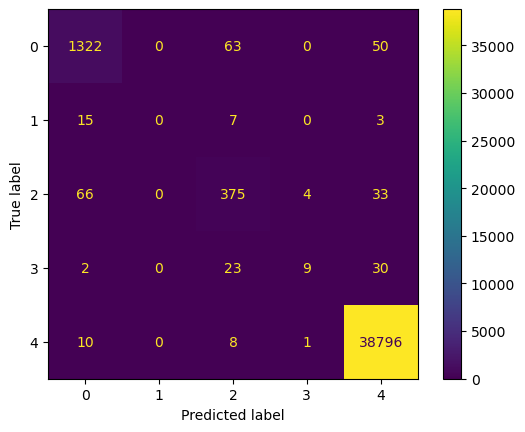

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(hotid_test, pred_hotid, labels=ohe.categories_[0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ohe.categories_[0])
disp.plot()
# disp.invert_yaxis()
# plt.savefig('imgs/cls-cm.png')
plt.show()


In [30]:
def plot_reg(test_data, pred_data, label_x, nbin, bin_range):
    plt.figure(figsize=(5, 5))
    plt.hist(test_data, label='Test data', histtype='step', bins=nbin, range=bin_range)
    plt.hist(pred_data, label='Prediction data', histtype='step', bins=nbin, range=bin_range)
    plt.ylabel('counts')
    plt.xlabel(label_x)
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    # plt.savefig("imgs/"+label_x+".png")
    plt.legend(loc='upper left')
    plt.show()

In [31]:
pred_y = y_pred.squeeze().detach().numpy()

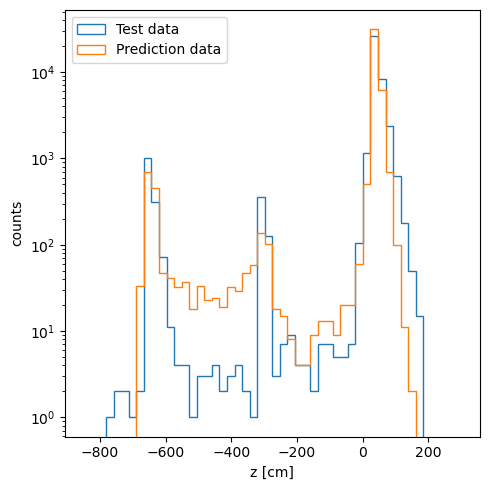

In [32]:
plot_reg(y_test[:, 2], pred_y[:, 2], 'z [cm]', 50, [-850., 300.])

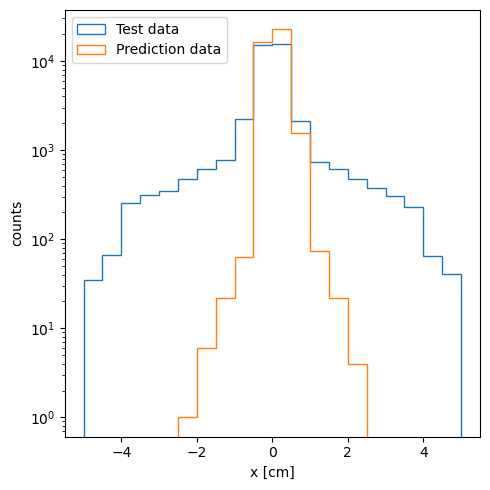

In [33]:
plot_reg(y_test[:, 0], pred_y[:, 0], 'x [cm]', 20, [-5., 5.])

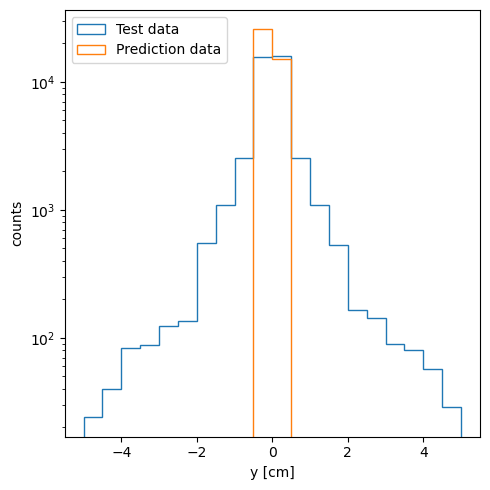

In [34]:
plot_reg(y_test[:, 1], pred_y[:, 1], 'y [cm]', 20, [-5., 5.])

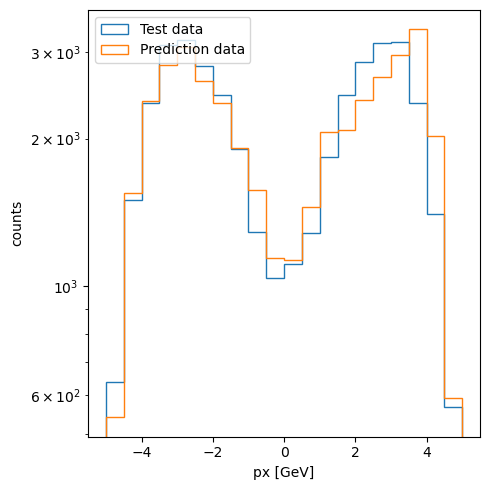

In [35]:
plot_reg(y_test[:, 3], pred_y[:, 3], 'px [GeV]', 20, [-5., 5.])

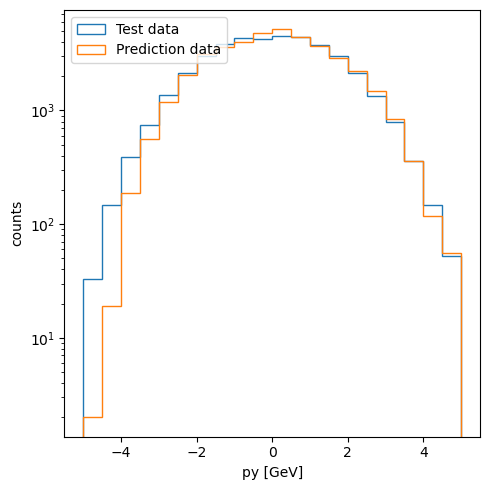

In [36]:
plot_reg(y_test[:, 4], pred_y[:, 4], 'py [GeV]', 20, [-5., 5.])

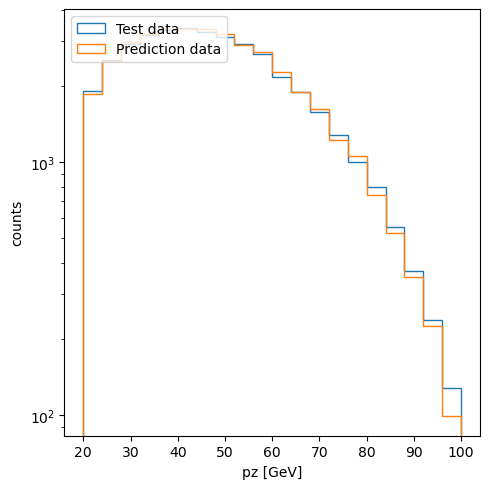

In [37]:
plot_reg(y_test[:, 5], pred_y[:, 5], 'pz [GeV]', 20, [20., 100.])

In [39]:
def resolution(true, preds, reco, nbin, bin_range, pname):
    
    set1 = true-preds
    set2 = true-reco
    
    mask1=((bin_range[0]<set1) & (set1<bin_range[1]))
    mask2=((bin_range[0]<set2) & (set2<bin_range[1]))
    
    set1=set1[mask1]
    set2=set2[mask2]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].hist(true-preds, bins=nbin, range=bin_range, histtype='step')
    ax[0].set_ylabel("counts")
    ax[0].set_xlabel("true - preds")
    ax[0].text(1, 5000, r"$\mu = $ {0:.4f}".format(np.mean(set1)))
    ax[0].text(1, 4000, r"$\sigma = $ {0:.4f}".format(np.std(set1)))
    
    ax[1].hist(true-reco, bins=nbin, range=bin_range, histtype='step')
    ax[1].set_xlabel("true - reco")
    ax[1].text(1, 2000, r"$\mu = $ {0:.4f}".format(np.mean(set2)))
    ax[1].text(1, 1000, r"$\sigma = $ {0:.4f}".format(np.std(set2)))
    
    fig.suptitle(pname)
    fig.tight_layout()
    # plt.savefig("imgs/"+pname+".png")
    plt.show()

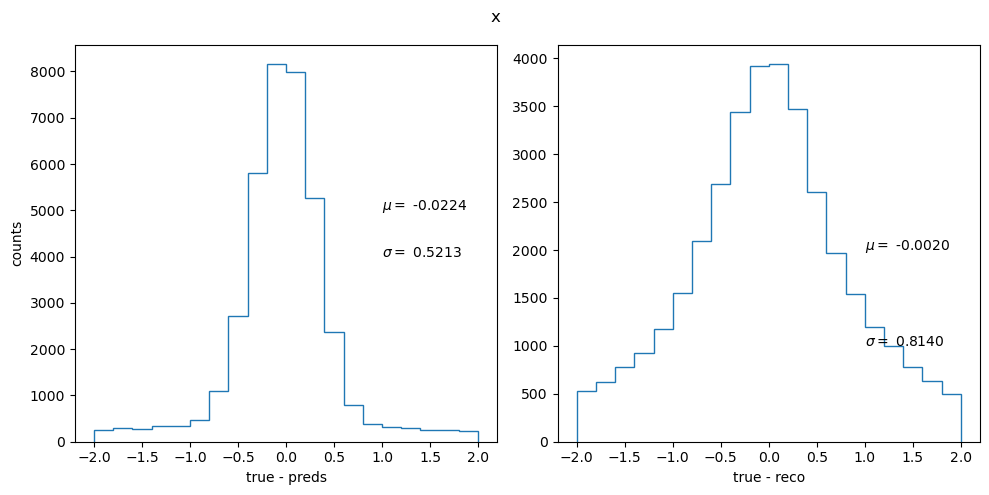

In [40]:
resolution(y_test[:, 0], pred_y[:, 0], reco_test[:, 0], 20, [-2., 2.], "x")

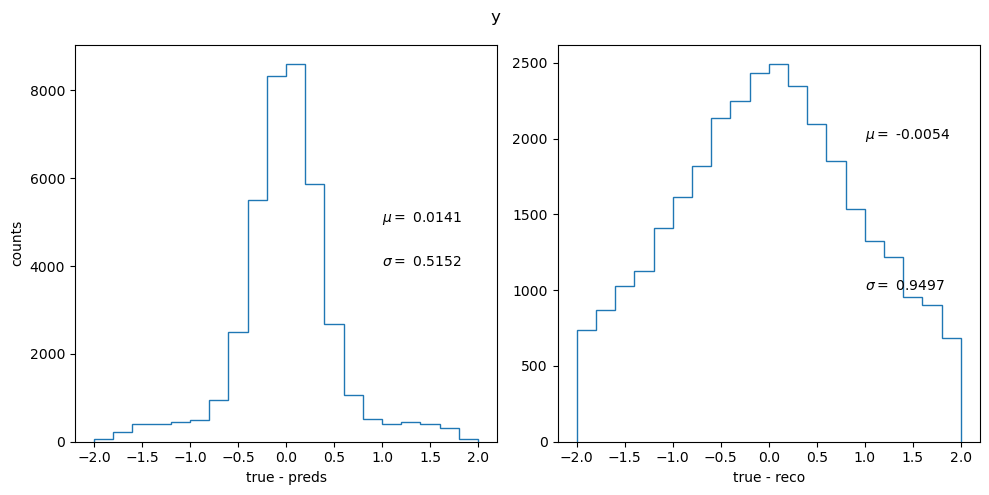

In [41]:
resolution(y_test[:, 1], pred_y[:, 1], reco_test[:, 1], 20, [-2., 2.], "y")

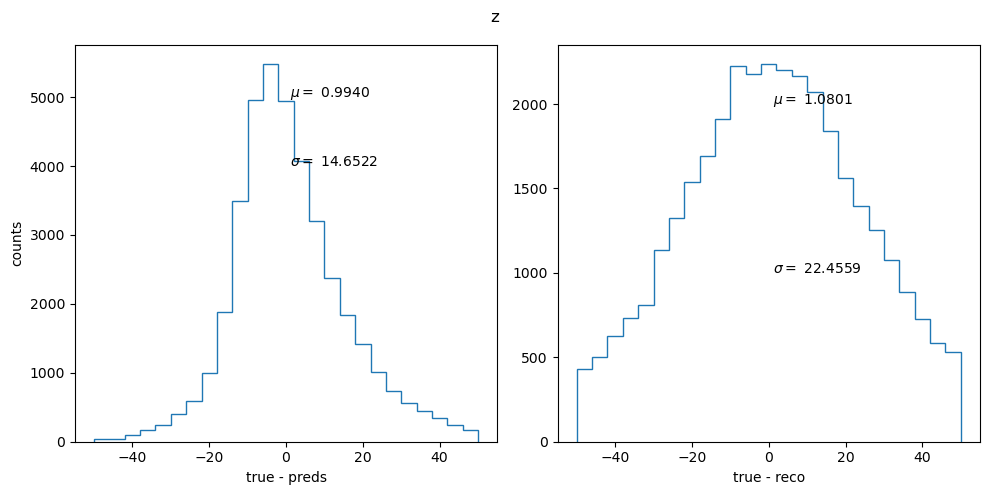

In [42]:
resolution(y_test[:, 2], pred_y[:, 2], reco_test[:, 2], 25, [-50., 50.], "z")

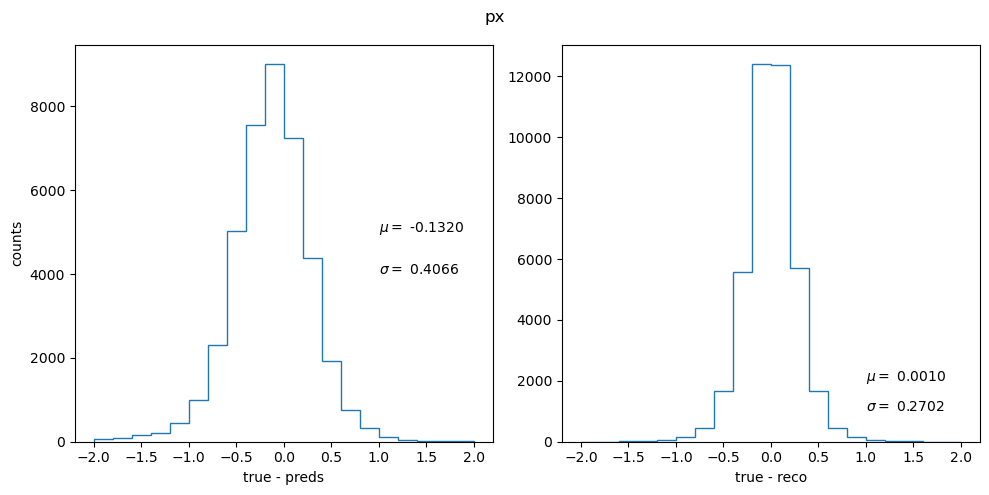

In [43]:
resolution(y_test[:, 3], pred_y[:, 3], reco_test[:, 3], 20, [-2., 2.], "px")

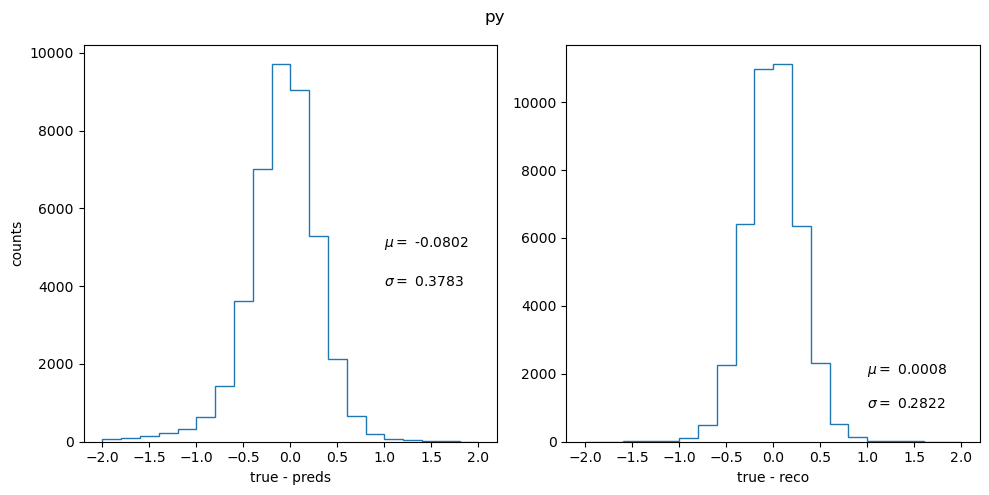

In [44]:
resolution(y_test[:, 4], pred_y[:, 4], reco_test[:, 4], 20, [-2., 2.], "py")

In [45]:
torch.save(net, "net.pt")